### Imports

In [1]:
import numpy
import pandas
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

numpy.random.seed(2023)

### Data Simulation
Let us simulate the following data for $n=100$ assets:
- vector of expected returns $\mu$
- covariance matrix $\Sigma$

Also, define the following:
- Risk aversion $\gamma = 2$
- Cost aversion $\kappa = 1.5$
- Cost matrix is an identity matrix multiplied by 0.1
- Previous weights are just equal weights so that they sum up to 1

In [2]:
n = 100

mu = numpy.random.uniform(-1, 1, n)
Sigma = numpy.random.randn(n, n)
Sigma = Sigma.T.dot(Sigma)
gamma = 2

kappa = 1.5
Cost_matrix = numpy.diag(n*[0.1])
prev_weights = numpy.ones_like(mu) / len(mu)

### Function for the general portfolio optimization solution

In [3]:
def calculate_optimal_portfolio(
    mu: numpy.ndarray, Sigma: numpy.ndarray, gamma: float,
    weights_sum: float,
    prev_weights: numpy.ndarray = None, C: numpy.ndarray = None, kappa: float = None,
) -> numpy.ndarray:
    """
    Solve a general portfolio optimization problem with quadratic transaction costs
    and return an optimal allocation.

    :param mu: expected returns
    :param Sigma: covariance matrix of returns
    :param gamma: risk aversion
    :param weights_sum: required sum of weights
    :param prev_weights: weights right before optimization
    :param C: cost matrix
    :param kappa: cost aversion
    :returns: optimal allocation
    """
    assert gamma != 0

    if kappa is None or kappa == 0:
        kappa = 0
        C = numpy.zeros_like(Sigma)
        prev_weights = numpy.zeros_like(mu) # can be whatever in this case
    elif C is None:
        kappa = 0
        C = numpy.zeros_like(Sigma)

    assert len(mu) == len(prev_weights) == Sigma.shape[0] == Sigma.shape[1] == C.shape[0] == C.shape[1]


    mu_tilde = calculate_mu_tilde(mu=mu, kappa=kappa, Sigma=Sigma, prev_weights=prev_weights)
    Sigma_tilde = calculate_sigma_tilde(Sigma=Sigma, kappa=kappa, gamma=gamma, C=C)

    unit_vector = numpy.ones_like(mu)
    Sigma_tilde_inv = numpy.linalg.inv(Sigma_tilde)
    A_tilde = unit_vector.T @ Sigma_tilde_inv @ unit_vector
    B_tilde = mu_tilde.T @ Sigma_tilde_inv @ unit_vector

    w_gmv_tilde = 1/A_tilde * Sigma_tilde_inv @ unit_vector
    wb_tilde    = 1/B_tilde * Sigma_tilde_inv @ mu_tilde

    optimal_w = B_tilde / gamma * wb_tilde + (gamma * weights_sum - B_tilde) / gamma * w_gmv_tilde

    return optimal_w


def calculate_mu_tilde(mu: numpy.ndarray, kappa: float, Sigma: numpy.ndarray, prev_weights: numpy.ndarray):
    return mu + kappa * Sigma @ prev_weights

def calculate_sigma_tilde(Sigma: numpy.ndarray, kappa: float, gamma: float, C: numpy.ndarray):
    return Sigma + kappa/gamma * C

In [4]:
w_star = calculate_optimal_portfolio(
    mu=mu, Sigma=Sigma, gamma=gamma,
    prev_weights=prev_weights, C=Cost_matrix, kappa=kappa,
    weights_sum=1
)
w_star[:10]

array([-0.28655002,  0.04775148, -0.73192009,  1.0522255 , -0.41180108,
       -0.31184928, -0.01681196, -1.1272075 , -0.18603517,  0.54959631])

### Tests
Now we will test our general solution by comparing its solution to those for special cases.

In [5]:
def calculate_gmv_portfolio(Sigma: numpy.ndarray) -> numpy.ndarray:
    unit_vector = numpy.ones_like(Sigma[0, :])
    Sigma_inv = numpy.linalg.inv(Sigma)
    A = unit_vector.T @ Sigma_inv @ unit_vector

    return 1/A * Sigma_inv @ unit_vector

def calculate_unconstrained_scaled_portfolio(mu: numpy.ndarray, Sigma: numpy.ndarray) -> numpy.ndarray:
    unit_vector = numpy.ones_like(mu)
    Sigma_inv = numpy.linalg.inv(Sigma)
    B = mu.T @ Sigma_inv @ unit_vector
    return 1/B * Sigma_inv @ mu

#### 1. UCS test
Compare our general solution function wit that for the unconstrained scaled portfolio

In [10]:
w_ucs = calculate_unconstrained_scaled_portfolio(mu=mu, Sigma=Sigma)

In [11]:
unit_vector = numpy.ones_like(mu)
Sigma_inv = numpy.linalg.inv(Sigma)
B = mu.T @ Sigma_inv @ unit_vector

w_ucs_star = calculate_optimal_portfolio(
    mu=mu, Sigma=Sigma, 
    gamma=B, # <- implied gamma for the UCS solution
    kappa=0, # <- no transaction costs
    weights_sum=1
)

In [12]:
numpy.abs(w_ucs - w_ucs_star).max()

0.0

#### 2. Constrained + unit sum test
Now, compare the general solution to that for when we constrain the sum of weights to be 1.

In [13]:
def calculate_constrained_portfolio(
    mu: numpy.ndarray, Sigma: numpy.ndarray, gamma: float, weights_sum: numpy.ndarray
) -> numpy.ndarray:

    unit_vector = numpy.ones_like(mu)
    Sigma_inv = numpy.linalg.inv(Sigma)

    A = unit_vector.T @ Sigma_inv @ unit_vector
    B = mu.T @ Sigma_inv @ unit_vector

    w_gmv = 1/A * Sigma_inv @ unit_vector
    wb = 1/B * Sigma_inv @ mu

    return B/gamma * wb + (gamma*weights_sum - B)/gamma * w_gmv

In [14]:
for ws in numpy.linspace(-1, 1, 100):

    wc = calculate_constrained_portfolio(
        mu=mu, Sigma=Sigma, gamma=gamma,
        weights_sum=ws # <--
    )

    wc_optimal = calculate_optimal_portfolio(
        mu=mu, Sigma=Sigma, gamma=gamma,
        weights_sum=ws, # <--
    )

    assert numpy.abs(wc - wc_optimal).max() == 0

### Plots

In [15]:
mu_tilde = calculate_mu_tilde(mu=mu, kappa=kappa, Sigma=Sigma, prev_weights=prev_weights)

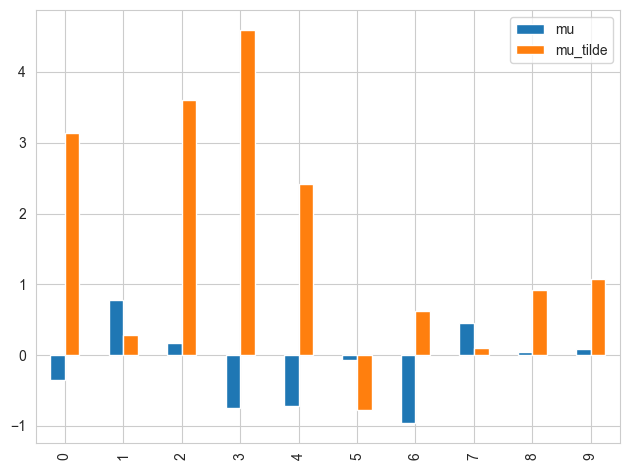

In [16]:
pandas.DataFrame(
    {
        'mu': mu[:10],
        'mu_tilde': mu_tilde[:10]
    }
).plot(kind='bar')

plt.tight_layout();

In [17]:
numpy.argmax(mu), numpy.argmax(mu_tilde)

(68, 33)

In [18]:
numpy.argmin(mu), numpy.argmin(mu_tilde)

(85, 40)

In [19]:
numpy.abs(mu - mu_tilde).mean() # average absolute change in mu

1.613039353789456

In [20]:
Sigma_tilde = calculate_sigma_tilde(Sigma=Sigma, gamma=gamma, kappa=kappa, C=Cost_matrix)
Sigma_tilde_diagonal = numpy.diag(Sigma_tilde)

Sigma_diagonal = numpy.diag(Sigma)

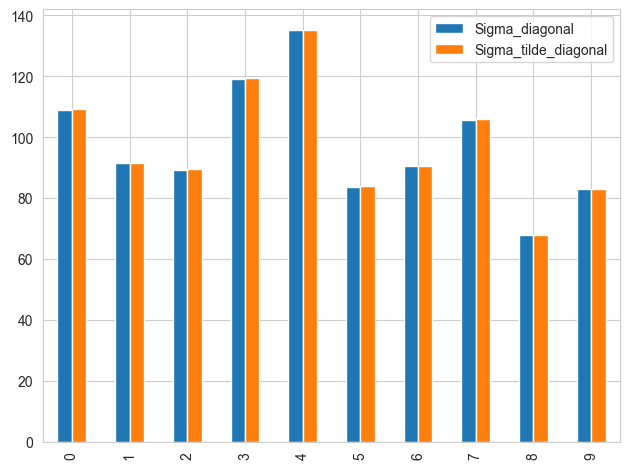

In [21]:
pandas.DataFrame(
    {
        'Sigma_diagonal': Sigma_diagonal[:10],
        'Sigma_tilde_diagonal': Sigma_tilde_diagonal[:10]
    }
).plot(kind='bar')

plt.tight_layout();

### Tests with cvxpy

In [22]:
import cvxpy as cp

##### Unconstrained optimization

In [23]:
w_cp = cp.Variable(n)
gamma_cp = cp.Parameter(nonneg=True)
ret = w_cp.T @ mu
risk = cp.quad_form(w_cp, Sigma) # w.T @ Sigma @ w
prob = cp.Problem(
    objective=cp.Maximize(ret - gamma/2 * risk),
    # constraints=[cp.sum(w_cp) == 1]
)

gamma_cp.value = gamma
prob.solve()

print(f'Status: {prob.solution.status}')
# print(f'Optimal allocation:', w_cp.value)

Status: optimal


In [24]:
w_unconstrained = 1/gamma * numpy.linalg.inv(Sigma) @ mu
assert numpy.abs(w_unconstrained - w_cp.value).max() < 1e-6

##### Constrained optimization

In [25]:
constrained_opt_test_results = {}

for weights_sum in numpy.linspace(-1, 1, 20):
    print(f'Sum of weights = {weights_sum}')
    constrained_opt_test_results[weights_sum] = {}

    ### Closed-form solution
    w_constrained = calculate_constrained_portfolio(
        mu=mu, Sigma=Sigma, gamma=gamma, weights_sum=weights_sum
    )
    constrained_opt_test_results[weights_sum]['closed-form solution'] = w_constrained

    ### CVXPY solution
    w_cp = cp.Variable(n)
    gamma_cp = cp.Parameter(nonneg=True)
    ret = w_cp.T @ mu
    risk = cp.quad_form(w_cp, Sigma) # w.T @ Sigma @ w
    prob = cp.Problem(
        objective=cp.Maximize(ret - gamma/2 * risk),
        constraints=[cp.sum(w_cp) == weights_sum]
    )
    gamma_cp.value = gamma
    prob.solve()
    print(f'CVXPY status: {prob.solution.status}')
    # print(f'Optimal allocation:', w_cp.value)
    constrained_opt_test_results[weights_sum]['CVXPY solution'] = w_cp.value

    constrained_opt_test_results[weights_sum]['allocation diff'] = w_constrained - w_cp.value
    constrained_opt_test_results[weights_sum]['max absolute diff'] = numpy.abs(
        constrained_opt_test_results[weights_sum]['allocation diff']
    ).max()
    assert constrained_opt_test_results[weights_sum]['max absolute diff'] < 1e-6
    
    print(50*'-')

Sum of weights = -1.0
CVXPY status: optimal
--------------------------------------------------
Sum of weights = -0.8947368421052632
CVXPY status: optimal
--------------------------------------------------
Sum of weights = -0.7894736842105263
CVXPY status: optimal
--------------------------------------------------
Sum of weights = -0.6842105263157895
CVXPY status: optimal
--------------------------------------------------
Sum of weights = -0.5789473684210527
CVXPY status: optimal
--------------------------------------------------
Sum of weights = -0.4736842105263158
CVXPY status: optimal
--------------------------------------------------
Sum of weights = -0.368421052631579
CVXPY status: optimal
--------------------------------------------------
Sum of weights = -0.26315789473684215
CVXPY status: optimal
--------------------------------------------------
Sum of weights = -0.1578947368421053
CVXPY status: optimal
--------------------------------------------------
Sum of weights = -0.05263

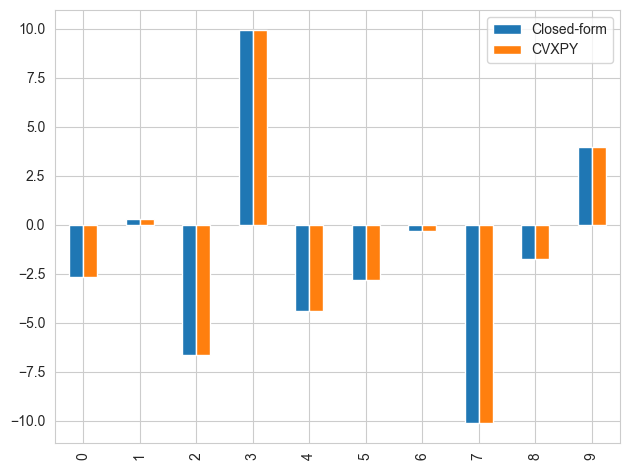

In [26]:
pandas.DataFrame(
    {
        'Closed-form': w_constrained[:10],
        'CVXPY': w_cp.value[:10]
    }
).plot(kind='bar')

plt.tight_layout();

#### TODO Constrained with transaction costs

In [27]:
w_optimal = calculate_optimal_portfolio(
    mu=mu, Sigma=Sigma, gamma=gamma, weights_sum=0,
    prev_weights=prev_weights, C=Cost_matrix, kappa=kappa,
)

In [28]:
### CVXPY solution
w_cp = cp.Variable(n)

gamma_cp = cp.Parameter(nonneg=True)
kappa_cp = cp.Parameter(nonneg=True)
prev_weights_cp = cp.Parameter(n)

ret = w_cp.T @ mu
risk = cp.quad_form(w_cp, Sigma) # w.T @ Sigma @ w
turnover = w_cp - prev_weights_cp # cp.abs(w_cp - prev_weights_cp)
cost = turnover.T @ Cost_matrix @ turnover # cp.quad_form(turnover, Cost_matrix)
prob = cp.Problem(
    objective=cp.Maximize(ret - gamma/2 * risk - kappa/2 * cost),
    constraints=[cp.sum(w_cp) == weights_sum]
)

gamma_cp.value = gamma
kappa_cp.value = kappa
prev_weights_cp.value = prev_weights

prob.solve(verbose=True)
print(f'CVXPY status: {prob.solution.status}')
print(f'Optimal allocation:', w_cp.value)

                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) Feb 22 01:07:15 AM: Your problem has 100 variables, 1 constraints, and 100 parameters.
(CVXPY) Feb 22 01:07:16 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 22 01:07:16 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 22 01:07:16 AM: Compiling problem (target solver=OSQP).
(CVXPY) Feb 22 01:07:16 AM: Reduction chain: FlipObjective -> CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> OSQP
(CVXPY) Feb 22 01:07:16 AM: Applying reduction FlipObjective
(CVXPY) Feb 22 01:07:16 AM: Applying reduc

In [29]:
numpy.abs(w_cp.value - w_optimal).max()

0.2101659312846979

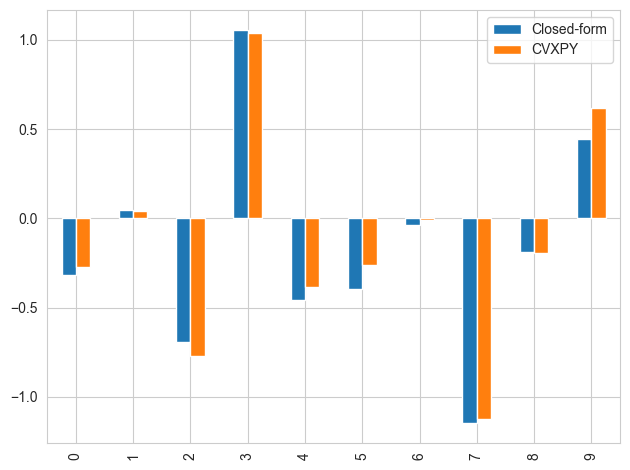

In [30]:
pandas.DataFrame(
    {
        'Closed-form': w_optimal[:10],
        'CVXPY': w_cp.value[:10]
    }
).plot(kind='bar')

plt.tight_layout();